In [4]:
import csv
import os
import sys
import random
import string
import numpy as np
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rc
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql import SQLContext
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs

# Initialize a spark session
spark = SparkSession \
    .builder \
    .appName("Veracity Detection") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# matplotlib inline backend
%matplotlib inline

## Data Preprocessing 
- Data sampling 
- Data cleaning 
- Data preparation and formatting
- Feature extraction

#### Imbalanced Sampling of Data

In [5]:
# Label the datasets, remove unncessary fields, sample and save the samples

# This imbalanced sample will favor the fake label with a ratio of 2 to 1
fake = pd.read_csv('../data/Fake.csv')
fake['label'] = 'Fake'
fake = fake.drop(columns=['date', 'subject'])
fake = fake.sample(3050, random_state=123)
true = pd.read_csv('../data/True.csv')
true['label'] = 'True'
true = true.drop(columns=['date', 'subject'])
true = true.sample(1475, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Imbalanced_Sample1_Fake.csv", index=False, header=None)
true.to_csv("../data/Imbalanced_Sample1_True.csv", index=False, header=None)

# This imbalanced sample will favor the fake label with a ratio of 2 to 1
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(21000, random_state=123)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(10000, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Imbalanced_Sample2_Fake.csv", index=False, header=None)
true.to_csv("../data/Imbalanced_Sample2_True.csv", index=False, header=None)

# This imbalanced sample favors the true label with ratio of 2 to 1
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(11000, random_state=123)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(20000, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Imbalanced_Sample3_Fake.csv", index=False, header=None)
true.to_csv("../data/Imbalanced_Sample3_True.csv", index=False, header=None)

# All the data with imbalance of ~10% favoring fake class
fake = pd.read_csv('../data/Fake.csv')
fake['label'] = 'Fake'
fake = fake.drop(columns=['date', 'subject'])
true = pd.read_csv('../data/True.csv')
true['label'] = 'True'
true = true.drop(columns=['date', 'subject'])

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Imbalanced_Sample4_Fake.csv", index=False, header=None)
true.to_csv("../data/Imbalanced_Sample4_True.csv", index=False, header=None)

#### Balanced Sampling of Data

In [6]:
# Label the datasets, remove unncessary fields, sample and save the samples

# 10% balanced sample
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(2300, random_state=123)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(2200, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Balanced_Sample1_Fake.csv", index=False, header=None)
true.to_csv("../data/Balanced_Sample1_True.csv", index=False, header=None)

fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(15750, random_state=123)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(15000, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Balanced_Sample2_Fake.csv", index=False, header=None)
true.to_csv("../data/Balanced_Sample2_True.csv", index=False, header=None)

# Largest(~ 41000) balanced sample
fake = pd.read_csv("../data/Fake.csv")
fake['label'] = 'Fake'
fake = fake.drop(columns=["date", "subject"])
fake = fake.sample(22000, random_state=123)
true = pd.read_csv("../data/True.csv")
true['label'] = 'True'
true = true.drop(columns=["date", "subject"])
true = true.sample(21000, random_state=123)

# Uncomment and run the cell to save the sample
fake.to_csv("../data/Balanced_Sample3_Fake.csv", index=False, header=None)
true.to_csv("../data/Balanced_Sample3_True.csv", index=False, header=None)

#### Collecting Stop Words
Stop words were extracted from nltk, python string module and the articles themselves

In [7]:
with open('../data/stop_punc.txt', 'r') as file:
    stop_punc = file.read()
stop_punc = stop_punc.split(',')
stop_punc = list(set(stop_punc))
stop_punc.append(',')

#### Data Cleaning and Formatting

In [8]:
fake_file = '../data/Imbalanced_Sample4_Fake.csv'
true_file = '../data/Imbalanced_Sample4_True.csv'

# Filtering datapoints with missing features
fake_rdd = spark.read.csv(fake_file).rdd
fake_rdd = fake_rdd.filter(lambda x: x[0] is not None and x[1] is not None).map(lambda x: (x[0] + ' ' + x[1], x[2])).filter(lambda x: x[1]=='Fake')
n_fake = fake_rdd.count()
true_rdd = spark.read.csv(true_file).rdd
true_rdd = true_rdd.filter(lambda x: x[0] is not None and x[1] is not None).map(lambda x: (x[0] + ' ' + x[1], x[2])).filter(lambda x: x[1]=='True')
n_true = true_rdd.count()

# Tokenizing articles and removing stop words from the article
tokenizer = Tokenizer(inputCol="article", outputCol="words")
fake_rdd = fake_rdd.map(lambda x: Row(article=x[0], label=x[1]))
fake_df = spark.createDataFrame(fake_rdd)
fake_df = tokenizer.transform(fake_df)
fake_rdd = fake_df.rdd.map(lambda x: (x[0], [i for i in x[2] if i not in stop_punc], x[1]))
true_rdd = true_rdd.map(lambda x:Row(article=x[0], label=x[1]))
true_df = spark.createDataFrame(true_rdd)
true_df = tokenizer.transform(true_df)
true_rdd = true_df.rdd.map(lambda x: (x[0], [i for i in x[2] if i not in stop_punc], x[1]))

#### Feature Extraction Using TFIDF

In [9]:
n_features = 10

fake_rdd = fake_rdd.map(lambda x: (x[1], x[2])).map(lambda x: Row(words=x[0], label=x[1]))
fake_df = spark.createDataFrame(fake_rdd)
hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=n_features)
fake_df = hashingTF.transform(fake_df)
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(fake_df)
fake_df = idfModel.transform(fake_df)
fake_rdd = fake_df.rdd.map(lambda x: (x[3], x[1])).map(lambda x: ([np.take(x[0], i) for i in range(np.size(x[0]))], x[1]))

true_rdd = true_rdd.map(lambda x: (x[1], x[2])).map(lambda x: Row(words=x[0], label=x[1]))
true_df = spark.createDataFrame(true_rdd)
hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=n_features)
true_df = hashingTF.transform(true_df)
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(true_df)
true_df = idfModel.transform(true_df)
true_rdd = true_df.rdd.map(lambda x: (x[3], x[1])).map(lambda x: ([np.take(x[0], i) for i in range(np.size(x[0]))], x[1]))


fake = fake_rdd.collect()
true = true_rdd.collect()

### Defining Training and Test Sets Using KFold Cross Validation
Only run one of the two cells below

In [7]:
# Defining folds with stratification
stratification = True
kf = KFold(n_splits=5, shuffle=True, random_state=123)
fake_data = []
for train_index, test_index in kf.split(fake):
    train = []
    test = []
    for i in train_index:
        train.append(fake[i])
    for i in test_index:
        test.append(fake[i])
    fake_data.append((train, test))
true_data = []
for train_index, test_index in kf.split(true):
    train = []
    test = []
    for i in train_index:
        train.append(true[i])
    for i in test_index:
        test.append(true[i])
    true_data.append((train, test))
data = []
for i in range(len(fake_data)):
    true_data[i][0].extend(fake_data[i][0])
    true_data[i][1].extend(fake_data[i][1])
data = true_data

In [10]:
# Defining folds without stratification
stratification = False
fake.extend(true)
random.seed(123)
random.shuffle(fake)
fake_true = fake
data = []
kf = KFold(n_splits=5, shuffle=True, random_state=123)
for train_index, test_index in kf.split(fake_true):
    train = []
    test = []
    for i in train_index:
        train.append(fake_true[i])
    for i in test_index:
        test.append(fake_true[i])
    data.append((train, test))

### Classification Using KNN Classifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=11)
knn_accuracy = []
knn_predict = []
knn_f1 = []
for i in range(len(data)):
    knn.fit([j[0] for j in data[i][0]], [j[1] for j in data[i][0]])
    knn_accuracy.append(knn.score([j[0] for j in data[i][1]], [j[1] for j in data[i][1]]))
    knn_predict.append(knn.predict([j[0] for j in data[i][1]]))
for i in range(len(knn_predict)):
    knn_f1.append(f1_score([j[1] for j in data[i][1]], knn_predict[i].tolist(), pos_label="True"))
knn_average_f1 = sum(knn_f1)/len(knn_f1)

# KNN Result
print('Classification of', n_fake + n_true, 'datapoints containing')
print(n_fake, 'fake datapoints')
print(n_true, 'true datapoints')
if stratification:
    print('With stratification', end = ' ')
else:
    print('Without stratificaiton', end = ' ')
print('Using KNN classifier and 5fold cross validation resulted in average f1 score of', knn_average_f1)

Classification of 43638 datapoints containing
22314 fake datapoints
21324 true datapoints
Without stratificaiton Using KNN classifier and 5fold cross validation resulted in average f1 score of 0.9910602643629465


In [12]:
knn_f1

[0.9898754800418945,
 0.9905070618198657,
 0.9926376066378403,
 0.99028682436293,
 0.9919943489522015]

### Classification Using Random Forest Classifier

In [13]:
n_trees = 45
max_depth = 20
rfc = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, random_state=123)
rf_accuracy = []
rf_predict = []
rf_f1 = []
for i in range(len(data)):
    rfc.fit([j[0] for j in data[i][0]], [j[1] for j in data[i][0]])
    rf_accuracy.append(rfc.score([j[0] for j in data[i][1]], [j[1] for j in data[i][1]]))
    rf_predict.append(rfc.predict([j[0] for j in data[i][1]]))
for i in range(len(rf_predict)):
    rf_f1.append(f1_score([j[1] for j in data[i][1]], rf_predict[i].tolist(), pos_label="True"))
rf_average_f1 = sum(rf_f1)/len(rf_f1)

# Result
print('Classification of', n_fake + n_true, 'datapoints containing: ')
print(n_fake, 'fake datapoints')
print(n_true, 'true datapoints')
if stratification:
    print('With stratification', end = ' ')
else:
    print('Without stratificaiton', end = ' ')
print('Using random forest classifier with', n_trees, 'trees, max depth of', max_depth, 'and 5fold cross validation resulted in average f1 score of', rf_average_f1)

Classification of 43638 datapoints containing: 
22314 fake datapoints
21324 true datapoints
Without stratificaiton Using random forest classifier with 45 trees, max depth of 20 and 5fold cross validation resulted in average f1 score of 0.9999052514799007


In [14]:
rf_f1

[1.0, 1.0, 0.9998822559755093, 1.0, 0.9996440014239943]

### Plots

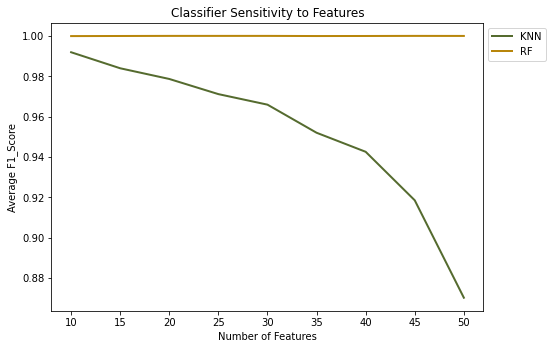

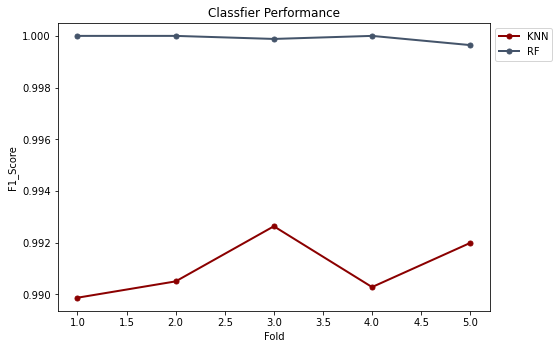

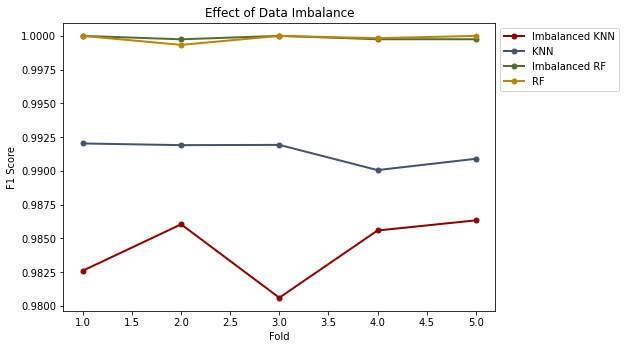

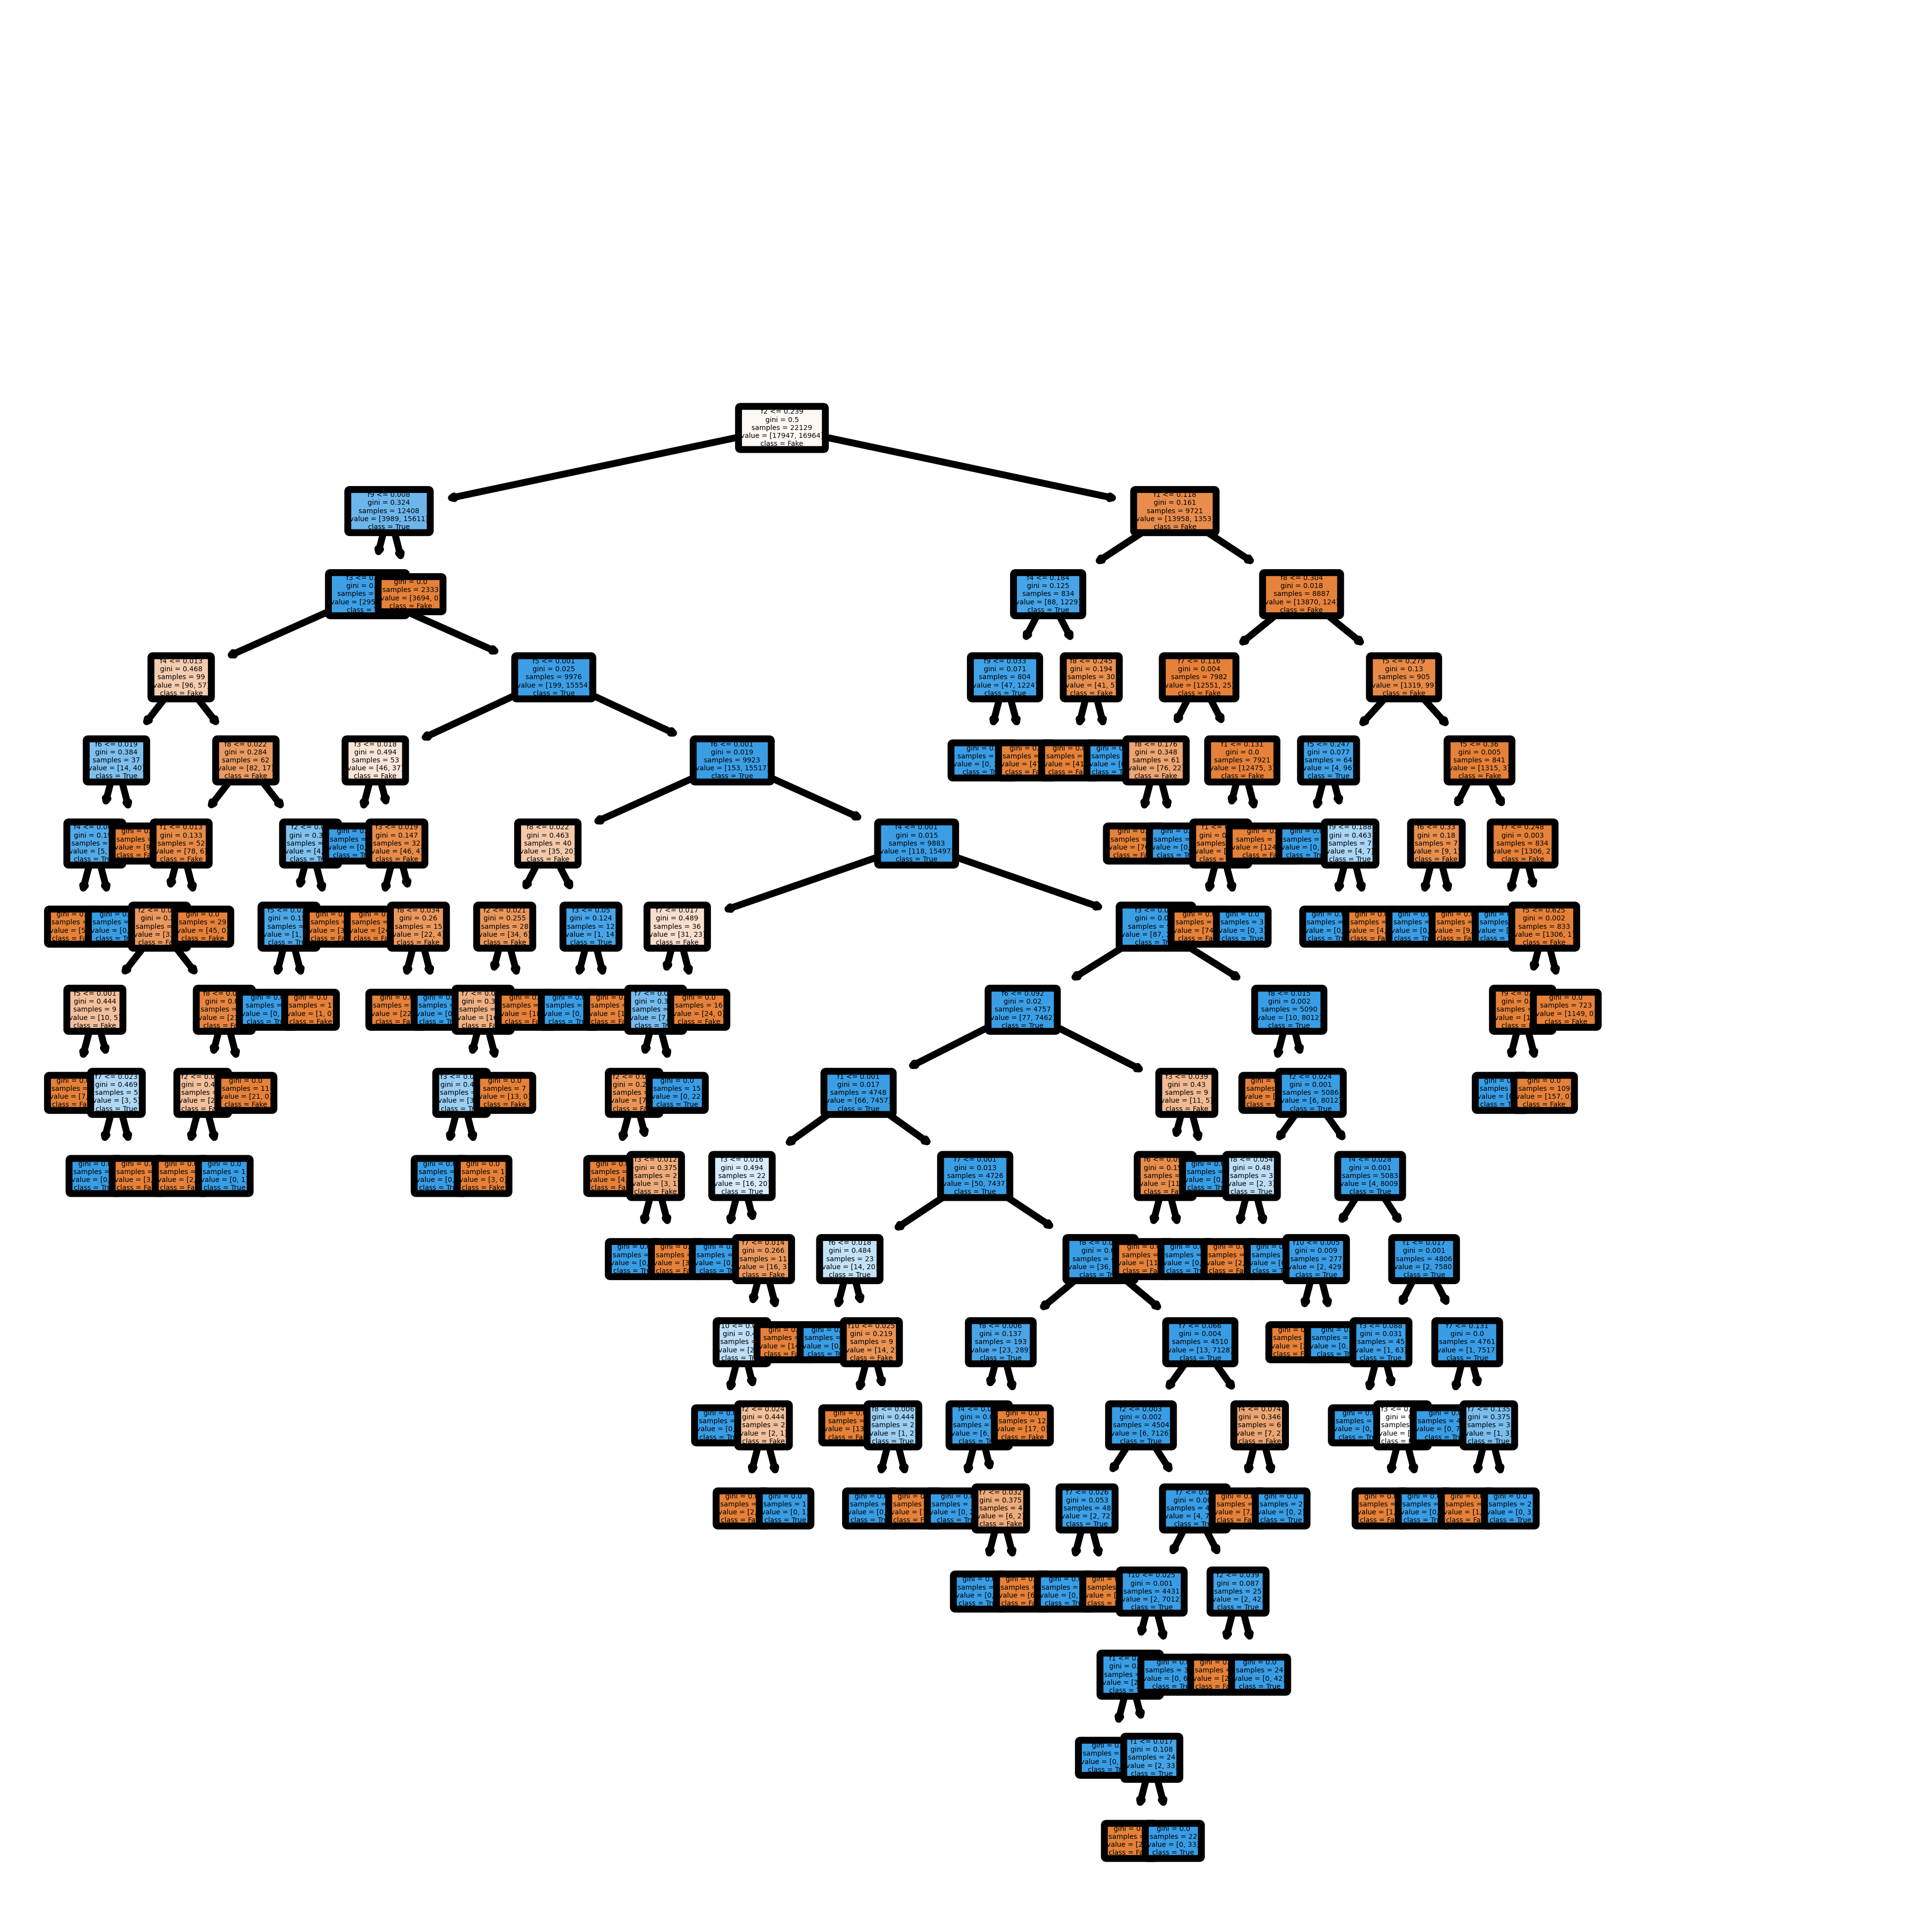

In [17]:
marker = '.'
markersize = 10
dpi = 300
# Plot for visualizing classifier sensitivity to features
# Data is derived from running tests on the Balanced_Sample2
y = [10, 15, 20, 25, 30, 35, 40, 45, 50]
knn_x = [0.99186491956141, 0.983915681661064, 0.978612415730856, 0.971100546536879, 0.965874003556011, 0.951946249464952, 0.942501584979348, 0.918441982272896, 0.870144989111527]
rf_x = [0.999880419964672, 0.999928249690847, 0.999976085136912, 0.999976085136912, 0.999976085136912, 0.999904346265489, 0.999928255410737, 0.999976085136912, 0.999952170273825]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(y, knn_x, color='#556B2F', lw=2)
ax.plot(y, rf_x, color='#B8860B', lw=2)
ax.legend(['KNN', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Average F1_Score')
ax.set_title('Classifier Sensitivity to Features')
# fig.savefig('../figures/classifier_sensitivity_to_features.png', bbox_inches='tight', dpi=dpi)

# Plot for visualizing the performance difference of the classifiers on the whole dataset (imbalance of ~10%)
folds = [1, 2, 3, 4, 5]
knn = [0.9898754800418945, 0.9905070618198657, 0.9926376066378403, 0.99028682436293, 0.9919943489522015]
rf = [1.0, 1.0, 0.9998822559755093, 1.0, 0.9996440014239943]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(folds, knn, color='#8B0000', lw=2, marker=marker, markersize=markersize)
ax.plot(folds, rf, color='#44546A', lw=2, marker=marker, markersize=markersize)
ax.legend(['KNN', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Fold')
ax.set_ylabel('F1_Score')
ax.set_title('Classfier Performance')
# fig.savefig('../figures/classifier_performance.png', bbox_inches='tight', dpi=dpi)

# Plot for Visualizing the effect of data Imbalance with ~30000 datapoints
folds = [1, 2, 3, 4, 5]
im_knn = [0.9826130153999006, 0.9860418743768694, 0.9806066633515664, 0.9855851453701442, 0.9863347974621767]
ba_knn = [0.99203187250996, 0.9919075144508671, 0.9919261822376009, 0.9900589721988207, 0.9908955470948518]
im_rf = [1.0, 0.9997471554993679, 1.0, 0.9997521685254027, 0.999752658916646]
ba_rf = [1.0, 0.9993342210386152, 1.0, 0.9998298451590948, 1.0]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(folds, im_knn, color='#8B0000', lw=2, marker=marker, markersize=markersize)
ax.plot(folds, ba_knn, color='#44546A', lw=2, marker=marker, markersize=markersize)
ax.plot(folds, im_rf, color='#556B2F', lw=2, marker=marker, markersize=markersize)
ax.plot(folds, ba_rf, color='#B8860B', lw=2, marker=marker, markersize=markersize)
ax.legend(['Imbalanced KNN', 'KNN', 'Imbalanced RF', 'RF'], bbox_to_anchor = (1.0, 1.0), loc='upper left')
ax.set_xlabel('Fold')
ax.set_ylabel('F1 Score')
ax.set_title('Effect of Data Imbalance')
# fig.savefig('../figures/effect_of_data_imbalance.png', bbox_inches='tight', dpi=dpi)

# Plot for visualizing a decision tree structure in the random forest from the Imbalanced_Sample4
fn = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
cn = ['Fake', 'True']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(rfc.estimators_[9], feature_names = fn, class_names=cn, filled = True, rounded=True)
plt.tight_layout()
# fig.savefig('../figures/rf_tree.png')